<a href="https://colab.research.google.com/github/pingwx/ya.prac/blob/main/10_Linear_algebra/10_EN_Linear_algebra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Protection of personal data

Our customer is the insurance company "Hot' potop" faced the problem of protecting the personal data of its clients. We are asked to develop a data transformation method applying which it would be not possible to recover the original client's data. At the same time, the quality of the model used by the customer for predictions should not become worse. It is known that the customer uses a linear regression model.
It is necessary to prove the correctness of the developed method.

## Loading data

In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np

In [3]:
df = pd.read_csv('/content/insurance.csv')

In [4]:
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [5]:
df.columns = ['sex', 'age', 'salary', 'family_size', 'insurance_count']

We loaded the data, looked at the first rows of the table and renamed columns

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sex              5000 non-null   int64  
 1   age              5000 non-null   float64
 2   salary           5000 non-null   float64
 3   family_size      5000 non-null   int64  
 4   insurance_count  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


We looked at the types of columns, made sure that there are no gaps.

In [7]:
df.describe()

,sex,age,salary,family_size,insurance_count
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


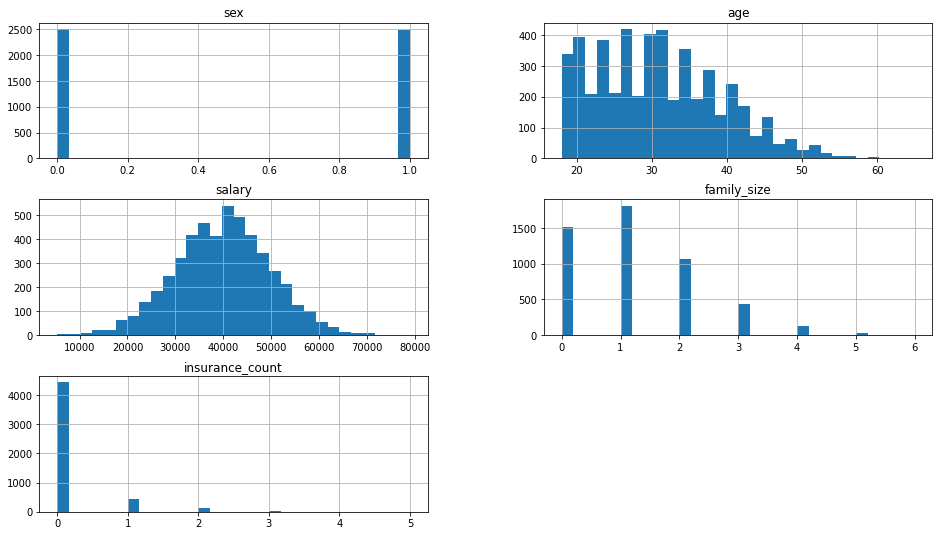

In [8]:
df.hist(figsize=(16,9), bins=30);

## Matrix multiplication

Let's answer the following question: features are multiplied by an invertible matrix. Will the quality of linear regression change? From the definition of an invertible matrix, we know that an invertible matrix is square. If the original feature matrix $X$ has size $(n\times m)$, then the matrix $P$, by which $X$ is multiplied, has the only possible size $(m\times m)$. Let's experiment and see what happens. First, we train the model on the initial features.

In [9]:
X = df.drop('insurance_count', axis=1).values
y = df['insurance_count'].values
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.25,
                                                      random_state=1)
model = LinearRegression()
model.fit(X_train, y_train)
predict = model.predict(X_valid)
r2 = r2_score(y_valid, predict)
r2

0.32377322792427543

Now we take random matrix $P$

In [10]:
np.random.seed(2007)
P = np.random.randint(100, size=(X_train.shape[1], (X_train.shape[1])))
P

array([[77, 15, 57, 63],
       [32, 77, 93, 72],
       [33, 29, 64, 50],
       [40, 94, 59, 25]])

Let us verify that $P$ is invertible.

In [11]:
np.linalg.inv(P)

array([[ 0.01252585, -0.01837464,  0.00490755,  0.01153873],
       [ 0.00621238,  0.02140565, -0.04103839,  0.00477333],
       [-0.02919413, -0.047035  ,  0.09804536,  0.01293927],
       [ 0.02549824,  0.05991678, -0.08493478, -0.02694636]])

Now we train the model on $X$ multiplied by $P$ features

In [12]:
model = LinearRegression()
model.fit(X_train@P, y_train)
predict = model.predict(X_valid@P)
r2 = r2_score(y_valid, predict)
r2

0.3237732279243868

We got the same R2-score as for the model trained on the initial features considering the computation error. Our assumption is as follows: multiplication of the feature matrix $X$ by the invertible matrix $P$ does not affect the prediction of the model. Let's try to establish whether this is so. To do this, we use the properties of transposed and inverse matrices __[here](https://en.wikipedia.org/wiki/Transpose)__ and __[here](https://en.wikipedia.org/wiki/Invertible_matrix)__, specifically $(AB)^T = B^TA^T$; $(AB)^{-1} = B^{-1}A^{-1}$.

It is known that linear regression model predictions are written as $a = Xw$, where $X$ is the feature matrix, $w$ is the vector of linear regression weights. It is known that

$$
w = (X^T X)^{-1} X^T y
$$
where $y$ - target vector. Let $X'$ = $XP$, the original matrix $X$ multiplied by some invertible matrix $P$. Then $w' = (X'^T X')^{-1} X'^T y$; $a'=X'w'.$ Let's compare $a$ and $a'$

$$
w' = (X'^T X')^{-1} X'^T y = ((XP)^TXP)^{-1}(XP)^Ty =
$$
$$
= P^{-1}((XP)^TX)^{-1}(XP)^Ty = P^{-1}(P^TX^TX)^{-1}P^TX^Ty =
$$
$$
= P^{-1}(X^TX)^{-1}(P^T)^{-1}P^TX^Ty = P^{-1}(X^TX)^{-1}X^Ty
$$

Then

$$
a'=X'w'=XPP^{-1}(X^TX)^{-1}X^Ty = X(X^TX)^{-1}X^Ty =
$$
$$
= Xw = a
$$

Thus, we made sure that the predictions of $a$ and $a'$ are equal, and our assumption that multiplying $X$ by $P$ does not affect the prediction of the linear regression model turned out to be correct.

## Transformation algorithm

Based on the above, the transformation algorithm for protecting clients data is described as follows. We multiply personal data, which is a matrix of features $X$ by some invertible matrix $P$, which we will keep secret. The linear regression model is trained on the transformed data. At the moment the model is used for prediction, the data for which the prediction needs to be made is also multiplied by the secret matrix $P$. For the reasons described above, the quality of the linear regression will remain unchanged and the original data will be protected.

## Algorithm test

The algorithm has, in fact, already been tested in Section 2 where we checked what will happen if we multiply the feature matrix by some other invertible matrix. Our customer is happy and the clients data is protected :)